# 线性回归的从零开始实现
:label:`sec_linear_scratch`

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。
在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


In [2]:
%matplotlib inline
import random
import tensorflow as tf
# from d2l import tensorflow as d2l
import matplotlib.pyplot as plt

## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


In [4]:
def synthetic_data(w, b, num_examples):  #@save
    """
    生成y=Xw+b+噪声的合成数据集

    参数:
    w (tf.Tensor): 线性模型的真实权重向量
    b (float): 线性模型的真实偏置项
    num_examples (int): 要生成的样本数量

    返回:
    tuple: 包含特征矩阵 X 和标签向量 y 的元组
    """
    # 创建一个形状为 (num_examples, w.shape[0]) 的零矩阵，用于存储特征
    X = tf.zeros((num_examples, w.shape[0]))
    # 向零矩阵 X 中添加从标准正态分布中采样得到的随机数，得到最终的特征矩阵
    X += tf.random.normal(shape=X.shape)
    # 根据线性模型公式 y = Xw + b 计算标签向量
    # 先将权重向量 w 转换为列向量，再进行矩阵乘法，最后加上偏置项 b
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    # 向计算得到的标签向量 y 中添加噪声，噪声服从均值为 0、标准差为 0.01 的正态分布
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    # 将标签向量 y 转换为形状为 (-1, 1) 的列向量
    y = tf.reshape(y, (-1, 1))
    # 返回生成的特征矩阵 X 和标签向量 y
    return X, y


In [6]:
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，[**`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）**]。


In [7]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([1.1639541  0.47367874], shape=(2,), dtype=float32) 
label: tf.Tensor([4.9196496], shape=(1,), dtype=float32)


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


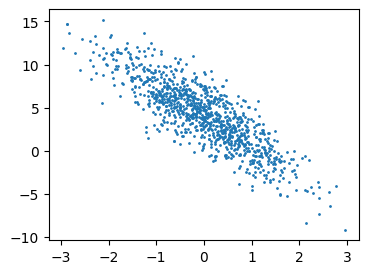

In [10]:
# d2l.set_figsize()
# d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

# 设置图形大小
plt.figure(figsize=(4, 3))

# 绘制散点图
plt.scatter(features[:, 1].numpy(), labels.numpy(), s=1)

# 显示图形
plt.show()

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。


In [11]:
def data_iter(batch_size, features, labels):
    """
    该函数用于生成小批量数据迭代器，用于模型训练时按批次获取数据。

    参数:
    batch_size (int): 每个小批量数据包含的样本数量。
    features (tf.Tensor): 特征矩阵，包含所有样本的特征数据。
    labels (tf.Tensor): 标签向量，包含所有样本对应的标签数据。

    返回:
    generator: 一个生成器，每次生成一个小批量的特征和对应的标签。
    """
    # 获取特征矩阵的样本数量
    num_examples = len(features)
    # 生成从 0 到 num_examples - 1 的索引列表
    indices = list(range(num_examples))
    # 随机打乱索引列表，确保样本是随机读取的，没有特定顺序
    random.shuffle(indices)
    # 从 0 开始，以 batch_size 为步长遍历索引列表
    for i in range(0, num_examples, batch_size):
        # 截取当前批次的索引，确保不超出样本数量
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        # 根据索引 j 从特征矩阵和标签向量中提取对应的数据，作为一个小批量返回
        yield tf.gather(features, j), tf.gather(labels, j)

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。
每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。
GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。
每个批量的特征维度显示批量大小和输入特征数。
同样的，批量的标签形状与`batch_size`相等。


In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.0925233   0.39763045]
 [-0.14393705  0.78517973]
 [-0.62924176 -0.6870892 ]
 [-1.2073183   0.97474223]
 [-0.6155586  -0.78098464]
 [ 0.27051237 -0.9271898 ]
 [ 0.5878594   1.0880158 ]
 [-1.0177809   0.7463462 ]
 [-0.5619468   0.74079555]
 [ 0.9709181   0.6837292 ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 3.0292745 ]
 [ 1.2513304 ]
 [ 5.2655983 ]
 [-1.5109243 ]
 [ 5.6272216 ]
 [ 7.889416  ]
 [ 1.6634022 ]
 [-0.35836488]
 [ 0.56118757]
 [ 3.8071423 ]], shape=(10, 1), dtype=float32)


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，
它可以处理存储在文件中的数据和数据流提供的数据。

## 初始化模型参数

[**在我们开始用小批量随机梯度下降优化我们的模型参数之前**]，
(**我们需要先有一些参数**)。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。


In [13]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用 :numref:`sec_autograd`中引入的自动微分来计算梯度。

## 定义模型

接下来，我们必须[**定义模型，将模型的输入和参数同模型的输出关联起来。**]
回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下 :numref:`subsec_broadcasting`中描述的广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。


In [14]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return tf.matmul(X, w) + b

## [**定义损失函数**]

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression`中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [15]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression`中讨论的，线性回归有解析解。
尽管线性回归有解析解，但本书中的其他模型却没有。
这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。
该函数接受模型参数集合、学习速率和批量大小作为输入。每
一步更新的大小由学习速率`lr`决定。
<u>因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。</u>


In [16]:
def sgd(params, grads, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    # 使用 zip 函数将参数列表 params 和梯度列表 grads 进行配对，然后遍历每一对参数和对应的梯度
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization`中详细介绍。


In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [18]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 计算l关于[w,b]的梯度
        dw, db = g.gradient(l, [w, b])
        # 使用参数的梯度更新参数
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.048240
epoch 2, loss 0.000204
epoch 3, loss 0.000049


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。
事实上，真实参数和通过训练学到的参数确实非常接近。


In [19]:
print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: [ 0.00082195 -0.00049543]
b的估计误差: [0.00012302]


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


1. 训练的起点不同，算法仍然有效。
2. 可以。理想状态下电压和电流是关于固定电阻的线性函数。
3. 从普朗克定律可知，光谱能量密度 ($B_{\lambda}(\lambda, T)$) 是波长 ($\lambda$) 和温度 ($T$) 的函数。如果已知光谱能量密度关于波长的分布，就可以预测物体的温度。
4. 在计算二阶导数时，可能会遇到梯度消失或梯度爆炸的问题。梯度消失指的是在反向传播过程中，梯度值变得非常小，导致模型无法有效地学习。梯度爆炸指的是梯度值变得非常大，导致模型无法有效地学习。解决这些问题的方法包括使用梯度裁剪、使用更稳定的优化算法（如Adam）、使用正则化等。
5. 在`squared_loss`函数中使用`reshape`函数是为了确保预测值和真实值的形状相同。这样可以避免在计算损失时出现形状不匹配的错误。

In [30]:
# 练习 6 预处理
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)
lr = 0.005
num_epochs = 3
net = linreg
loss = squared_loss

In [31]:
# 练习 6 训练
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 计算l关于[w,b]的梯度
        dw, db = g.gradient(l, [w, b])
        # 使用参数的梯度更新参数
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 6.064819
epoch 2, loss 2.338351
epoch 3, loss 0.903893


7. 会根据剩余个数切成一个更小的批次。

[Discussions](https://discuss.d2l.ai/t/1777)
